In [2]:
import netCDF4 as nc 
# miscellaneous operating system interfaces
import os

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

#processes the data
import numpy as np 
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.feature import BORDERS, COASTLINE


from matplotlib.colors import TwoSlopeNorm

import geopandas as gpd
from shapely.geometry import Point

In [3]:
# LOAD DATA
file_path = '../Data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [9]:
# try to reformat time into months
from datetime import datetime, timedelta

# Extract necessary variables
time_data = mascons.variables['time'][:]  # Time in days since 2002-01-01T00:00:00Z
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Shape (239, 360, 720)
only_land_mask = np.array(mascons["lwe_thickness"]) * np.array(mascons["land_mask"]) # Shape (360, 720)
print(only_land_mask.shape)
# Step 1: Convert time to datetime
start_date = datetime(2002, 1, 1)
time_dates = np.array([start_date + timedelta(days=int(t)) for t in time_data])

# Step 2: Create a pandas DataFrame for grouping
time_df = pd.DataFrame({'time': time_dates})
time_df['year_month'] = time_df['time'].dt.to_period('M')  # Convert to 'YYYY-MM' format for grouping

(239, 360, 720)


In [22]:
def plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index=None):
    """
    Plots the LWE thickness for a specific region defined by center latitude, center longitude,
    width, and height in degrees, applying a landmask.

    Parameters:
        center_lat (float): Center latitude of the region.
        center_lon (float): Center longitude of the region.
        width (float): Width of the region in degrees.
        height (float): Height of the region in degrees.
        time_index (int, optional): Index of the time step to plot. If None, defaults to the global variable i.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    # Adjust center_lon to match the dataset's range (0 to 360)
    if center_lon < 0:
        center_lon += 360

    # Calculate the bounds of the region
    lat_min = center_lat - height / 2
    lat_max = center_lat + height / 2
    lon_min = center_lon - width / 2
    lon_max = center_lon + width / 2

    # Filter the latitude and longitude indices
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    # Check if indices are valid
    if len(lat_indices) == 0 or len(lon_indices) == 0:
        print("No data available for the specified region.")
        return

    # Extract the subset of data
    subset_lat = lat[lat_indices]
    subset_lon = lon[lon_indices]
    time_idx = time_index if time_index is not None else i
    subset_lwe_thickness = only_land_mask[time_idx, lat_indices[:, None], lon_indices] #changed this to only_land_mask could be also lwe_thickness

    # Check if subset_lwe_thickness is valid
    if subset_lwe_thickness.size == 0:
        print("No LWE thickness data available for the specified region.")
        return

    # Create a figure and axis with a Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define a normalization that centers the colorbar at 0
    data_min = subset_lwe_thickness.min()
    data_max = subset_lwe_thickness.max()
    data_min=-data_max
    if data_min < 0 and data_max > 0:
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    else:
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    # Plot the lwe_thickness for the specified time step with the defined normalization
    lwe_plot = ax.pcolormesh(subset_lon, subset_lat, subset_lwe_thickness, 
                             cmap='seismic', norm=norm, transform=ccrs.PlateCarree())

    # Add coastlines, borders, and gridlines
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.gridlines(draw_labels=True)

    # Add a colorbar
    cbar = plt.colorbar(lwe_plot, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Liquid Water Equivalent Thickness')

    # Set the colorbar ticks and range
    #cbar.set_ticks(np.linspace(data_min, data_max, num=5))  # 5 evenly spaced ticks
    #cbar.ax.tick_params(labelsize=10)  # Adjust tick label size

    # Set the title
    ax.set_title(f'LWE Thickness for Month {time_idx + 1} in Region ({center_lat}, {center_lon})')
    
    return fig, data_min, data_max



In [ ]:
# LOAD DATA
data_path = '../Data/lpr_000b21a_e/lpr_000b21a_e.shp'

# Check if the file exists
if os.path.exists(data_path):
    print("File exists")
else:
    raise FileNotFoundError(f"File not found: {data_path}")



File exists


,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA,geometry
0,10,2021A000210,Newfoundland and Labrador / Terre-Neuve-et-Lab...,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,3.581704e+05,"MULTIPOLYGON (((8841194.729 2213093.663, 88411..."
1,11,2021A000211,Prince Edward Island / Île-du-Prince-Édouard,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,5.681179e+03,"MULTIPOLYGON (((8374335.443 1629502.597, 83743..."
2,12,2021A000212,Nova Scotia / Nouvelle-Écosse,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,5.282471e+04,"MULTIPOLYGON (((8310463.217 1250722.263, 83104..."
3,13,2021A000213,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,7.124850e+04,"MULTIPOLYGON (((7964100.72 1576822.289, 796410..."
4,24,2021A000224,Quebec / Québec,Quebec,Québec,Que.,Qc,1.298600e+06,"MULTIPOLYGON (((6948393.211 2760814.626, 69483..."
5,35,2021A000235,Ontario,Ontario,Ontario,Ont.,Ont.,8.924118e+05,"MULTIPOLYGON (((7146731.034 1071348.914, 71467..."
6,46,2021A000246,Manitoba,Manitoba,Manitoba,Man.,Man.,5.403102e+05,"MULTIPOLYGON (((6036427.023 2552091.071, 60364..."
7,47,2021A000247,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,5.770604e+05,"POLYGON ((5248633.914 2767057.263, 5249285.64 ..."
8,48,2021A000248,Alberta,Alberta,Alberta,Alta.,Alb.,6.346583e+05,"POLYGON ((5228304.177 2767597.891, 5228098.463..."
9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,9.206866e+05,"MULTIPOLYGON (((3843551.097 2389750.1, 3843548..."


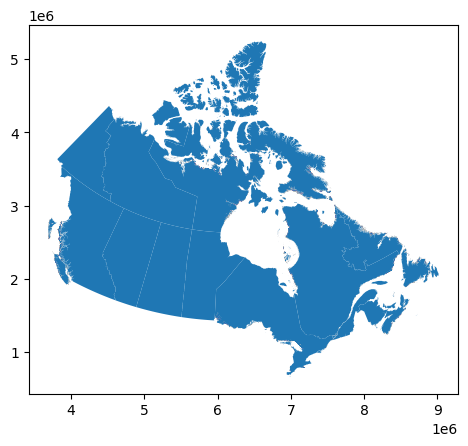

In [25]:
from shapely.geometry import Point
canada_shape = gpd.read_file('../Data/lpr_000b21a_e/lpr_000b21a_e.shp')
canada_shape.plot()
canada_shape

In [ ]:
canada_shape_map = canada_shape.to_crs("EPSG:4326")

# Define lat/lon grid
lat = np.linspace(-89.75, 89.75, 360)  # 360 lat points
lon = np.linspace(0.25, 359.75, 720)  # 720 lon points

# Create meshgrid
lon_grid, lat_grid = np.meshgrid(lon, lat)

from shapely.geometry import Point

# Flatten grid arrays to create 1D lists
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()

# Create points for the grid
geometry = [Point(xy) for xy in zip(lon_flat, lat_flat)]
grid_gdf = gpd.GeoDataFrame({"lat": lat_flat, "lon": lon_flat}, geometry=geometry, crs="EPSG:4326")

# Identify grid points inside the country
grid_gdf["land_mask"] = grid_gdf.geometry.within(nepal_shape_map.unary_union).astype(int)

# Reshape land mask…

data_min -475.5582770620887
data_max 475.5582770620887


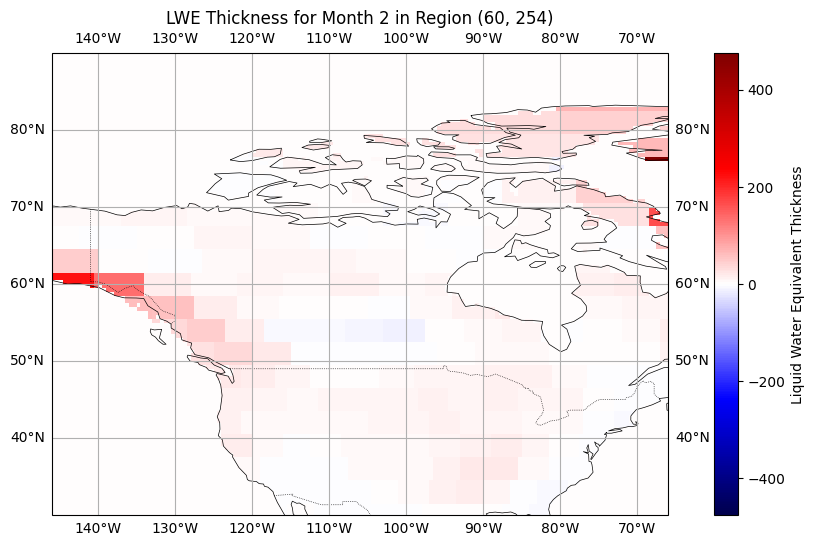

In [23]:
center_lat = 60
center_lon = -106
width = 80
height = 60
time_index = 1

lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]

# implement the shapefile HERE

# Plot the LWE thickness for the specified region
fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()

In [ ]:
center_lat = 60
center_lon = -106
width = 80
height = 60
time_index = 1

lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]

# implement the shapefile HERE

# Plot the LWE thickness for the specified region
fig = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
# Show the plot
plt.show()

In [ ]:
# Load the shapefile using geopandas
shapefile_path = '../Data/lpr_000b21a_e/lpr_000b21a_e.shp'
shapefile = gpd.read_file(shapefile_path)

# Filter the shapefile to the region of interest (optional, based on your needs)
# For example, filter by a specific attribute if needed:
# shapefile = shapefile[shapefile['ATTRIBUTE_NAME'] == 'VALUE']

# Create a mask for the region defined by the shapefile
geometry = shapefile.unary_union  # Combine all geometries into one
lon_grid, lat_grid = np.meshgrid(lon, lat)  # Create a grid of lon/lat values
points = np.array([lon_grid.flatten(), lat_grid.flatten()]).T
mask = np.array([geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)

# Apply the mask to the lwe_thickness data
masked_lwe_thickness = np.ma.masked_where(~mask, lwe_thickness[time_index])

# Plot the filtered LWE thickness
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
norm = TwoSlopeNorm(vmin=masked_lwe_thickness.min(), vcenter=0, vmax=masked_lwe_thickness.max())
lwe_plot = ax.pcolormesh(lon, lat, masked_lwe_thickness, cmap='seismic', norm=norm, transform=ccrs.PlateCarree())

# Add shapefile boundaries
shapefile.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree())

# Add coastlines, borders, and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax.gridlines(draw_labels=True)

# Add a colorbar
cbar = plt.colorbar(lwe_plot, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Liquid Water Equivalent Thickness')

# Set the title
ax.set_title(f'LWE Thickness for Month {time_index + 1} Filtered by Shapefile')

# Show the plot
plt.show()

/var/folders/y7/dv79l4qx6hl922vv5hjh19dc0000gn/T/ipykernel_66072/1246750884.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = shapefile.unary_union  # Combine all geometries into one


KeyboardInterrupt: 